# PyEddyTracker - Model Evaluation
## CONTENTS;
### 1. Load in data
This notebook will be used to make plots for the AMOS poster. I want to explore the difference in the eddy statistics and spatial patterns between the different outputs. 

All model data has been regridded to the aviso quarter degree grid prior to detrending and finally the eddy detection and tracks are found on that coarser grid. There are a few reasons for doing this. Firstly, the PET was not designed for such a high resolution grid, being mainly used on daily-to-weekly temporal frequency and quarter-to-one degree spatial frequency. Secondly, by regridding the high-resolution data on to the coarse resolution grid, we don't necessarily lose any information on the scales we are interested in evaluating, i.e., large-scale, long-lived eddies. 

Now, let's load in the four tracking datasets and start to explore the results...

In [10]:
from datetime import datetime

from matplotlib import pyplot as plt
from numpy import arange

from py_eddy_tracker import data
from py_eddy_tracker.dataset.grid import RegularGridDataset
from py_eddy_tracker.eddy_feature import Contours

from py_eddy_tracker.observations.network import NetworkObservations
from py_eddy_tracker.observations.observation import EddiesObservations, Table
from py_eddy_tracker.observations.tracking import TrackEddiesObservations

import xarray as xr
import glob
from netCDF4 import Dataset
from datetime import timedelta

import cartopy.crs as ccrs
import cartopy.feature as feature

In [11]:
# set paths to model output
# adt_datapath = '/home/johnr/utas/Documents/phd_folder/gadi_notebooks/data/subsetted_data/'
adt_datapath = '/scratch/v45/jr5971/mom6-setonix/subsetted_data/'

## SRM
eac_003 = adt_datapath + 'eac-rg-dt.nc'
## LRM
sthpac_01 = adt_datapath + 'sthpac-rg-dt.nc'
## PARENT
om2_01 = adt_datapath + 'om2-rg-dt.nc' 
# OBS
aviso = adt_datapath + 'avisodt.nc'
# set paths to track files
aviso_track = adt_datapath + '/track_files/avisodt/'
eac_track = adt_datapath + '/track_files/eac-rg-dt/'
sthpac_track = adt_datapath + '/track_files/sthpac-rg-dt/'
om2_track = adt_datapath + '/track_files/om2-rg-dt/' 

### Open ssh files and plot
Load SSH Data 

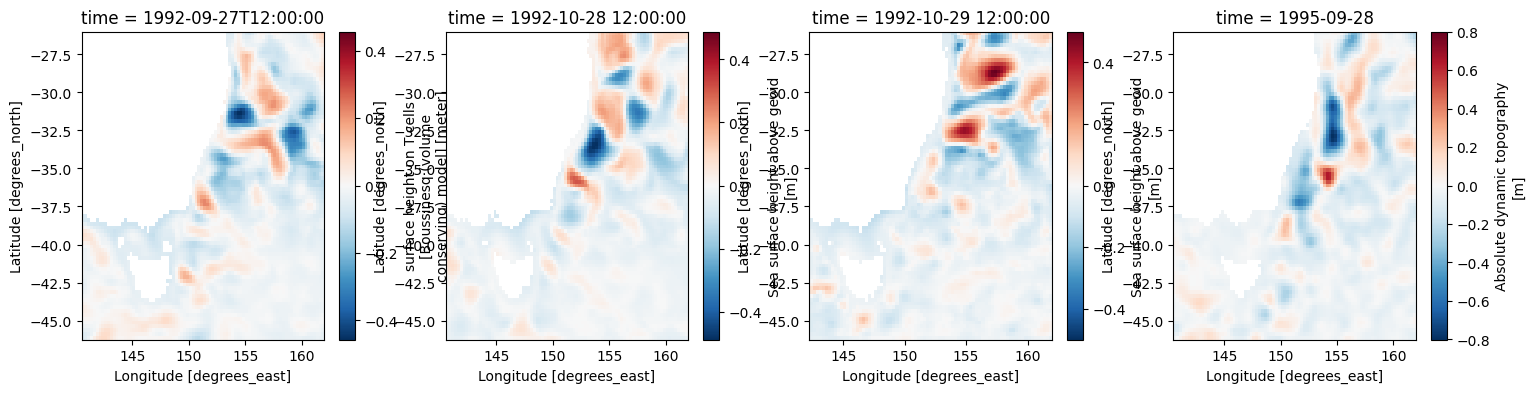

In [12]:
plt.figure(figsize=(18,4))
aviso_ssh = xr.open_dataarray(aviso)
eac_ssh = xr.open_dataarray(eac_003)
sthpac_ssh = xr.open_dataarray(sthpac_01)
om2_ssh = xr.open_dataarray(om2_01)

ssh_ls = [om2_ssh, sthpac_ssh, eac_ssh, aviso_ssh]

for i, ssh in enumerate(ssh_ls):
    plt.subplot(1,4,i+1)
    ssh.isel(time=1000).plot()

In [13]:
for ssh in ssh_ls:
    print(ssh.time.max().values)

2019-12-31T12:00:00.000000000
2018-12-31 12:00:00
2017-12-31 12:00:00
2020-06-03T00:00:00.000000000


Okay so that's something else that's good to be aware of. The OM2 data start at Jan 1st, 1990, the STHPAC data start on Feb 1st, 1990 whilst the EAC data start the day after on Feb 2nd, 1990. 

This should impact anything too much though. 

Right so we've got these four datasets. All have been detrended, and the three model sources have been regridded to the AVISO grid. What's next to do? 

I'd like to make some plots of these, as well as the geostrophic velocities associated with the SLA's too. From those we could make some nice streamplots. 

# Track Eddies
NOTE - the "tracking" has already been computed on all datasets, so here we'll just load those in and start plotting!

#### Steps for tracking eddies

In [14]:
from py_eddy_tracker.data import get_remote_demo_sample
from py_eddy_tracker.featured_tracking.area_tracker import AreaTracker
from py_eddy_tracker.gui import GUI
from py_eddy_tracker.tracking import Correspondances

In [15]:
# Get files of eddy detection
ac_eddy_files = glob.glob(adt_datapath+'id-eddies_eac-003-filtered-dask/AC*.nc'); ac_eddy_files.sort()
cc_eddy_files = glob.glob(adt_datapath+'id-eddies_eac-003-filtered-dask/CC*.nc'); cc_eddy_files.sort()
print(len(ac_eddy_files), len(cc_eddy_files))


0 0


In [7]:
%%time
# compute eddy tracks
ac_correspondances = Correspondances(datasets=ac_eddy_files, virtual=3)
cc_correspondances = Correspondances(datasets=cc_eddy_files, virtual=3)
# track eddies
ac_correspondances.track(); cc_correspondances.track()
ac_correspondances.prepare_merging(); cc_correspondances.prepare_merging()
# merge results
ac_eddytracks = ac_correspondances.merge(raw_data=False)
cc_eddytracks = cc_correspondances.merge(raw_data=False)
# capture virtual eddies required
ac_eddytracks.virtual[:] = ac_eddytracks.time==0
cc_eddytracks.virtual[:] = cc_eddytracks.time==0
# interpolate between virtual eddy tracks
ac_eddytracks.filled_by_interpolation(ac_eddytracks.virtual == 1)
cc_eddytracks.filled_by_interpolation(cc_eddytracks.virtual == 1)

High number of conflict : 4 (nb_conflict)
High number of conflict : 15 (nb_conflict)
High number of conflict : 6 (nb_conflict)
High number of conflict : 7 (nb_conflict)
High number of conflict : 6 (nb_conflict)
High number of conflict : 9 (nb_conflict)
High number of conflict : 9 (nb_conflict)
High number of conflict : 10 (nb_conflict)
High number of conflict : 9 (nb_conflict)
High number of conflict : 7 (nb_conflict)
High number of conflict : 8 (nb_conflict)
High number of conflict : 11 (nb_conflict)
High number of conflict : 14 (nb_conflict)
High number of conflict : 15 (nb_conflict)
High number of conflict : 11 (nb_conflict)
High number of conflict : 11 (nb_conflict)
High number of conflict : 12 (nb_conflict)
High number of conflict : 4 (nb_conflict)
High number of conflict : 9 (nb_conflict)
High number of conflict : 4 (nb_conflict)
High number of conflict : 8 (nb_conflict)
High number of conflict : 4 (nb_conflict)
High number of conflict : 12 (nb_conflict)
High number of conflict :

CPU times: user 10min 3s, sys: 2min, total: 12min 3s
Wall time: 25min 30s


In [8]:
print(ac_eddytracks)

/mnt/c/Users/johnr/OneDrive - University of Tasmania/Documents/phd_folder/gadi_notebooks/py-eddy-tracker/src/py_eddy_tracker/observations/observation.py:278: RuntimeWarning: invalid value encountered in true_divide
  v /= hist_numba(x, bins=bins)[0]


    | 76152 observations from 14642 to 18444 (3803 days, ~20 obs/day)
    |   Speed area      : 0.16 Mkm²/day
    |   Effective area  : 0.29 Mkm²/day
    ----Distribution in Amplitude:
    |   Amplitude bounds (cm)        0.00      1.00      2.00      3.00      4.00      5.00     10.00    500.00
    |   Percent of eddies         :       0.94     17.80     12.21      9.21      7.02     24.67     28.15
    ----Distribution in Radius:
    |   Speed radius (km)            0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.59     17.29     32.96     21.51     13.40     10.26      3.97      0.00
    |   Effective radius (km)        0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.16      8.00     16.49     19.34     19.07     21.83     15.12      0.00
    ----Distribution in Latitude
        Latitude bounds            -90.00    -60.00  

In [9]:
print(cc_eddytracks)

    | 84814 observations from 14642 to 18444 (3803 days, ~22 obs/day)
    |   Speed area      : 0.16 Mkm²/day
    |   Effective area  : 0.25 Mkm²/day
    ----Distribution in Amplitude:
    |   Amplitude bounds (cm)        0.00      1.00      2.00      3.00      4.00      5.00     10.00    500.00
    |   Percent of eddies         :       1.09     20.42     14.58     11.42      8.12     24.78     19.58
    ----Distribution in Radius:
    |   Speed radius (km)            0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       2.20     22.60     29.15     22.07     12.84      7.99      3.16      0.00
    |   Effective radius (km)        0.00     15.00     30.00     45.00     60.00     75.00    100.00    200.00   2000.00
    |   Percent of eddies         :       0.77     11.29     20.09     22.64     19.16     17.39      8.66      0.00
    ----Distribution in Latitude
        Latitude bounds            -90.00    -60.00  

Okay so now I've got these eddy tracks. Let's just work through a few of the examples to get a feel for how to play around with the data.

### Load tracking results and start plotting!
Here we use `extract_with_length` to extract eddies with tracks of a particular length. 
* `extract_with_length`: Return the observations within trajectories lasting between [b0:b1]
   * **NOTE: This is length in "days" not in distance!**

In [16]:
aviso_ac = TrackEddiesObservations.load_file(aviso_track + 'Anticyclonic.nc')
aviso_cc = TrackEddiesObservations.load_file(aviso_track + 'Cyclonic.nc')

model_tracks = dict()
for name, path in zip(['eac', 'sthpac', 'om2'], [eac_track, sthpac_track, om2_track]):
    model_tracks[name] = {'ac':TrackEddiesObservations.load_file(path+'Anticyclonic.nc'), 
                          'cc':TrackEddiesObservations.load_file(path+'Cyclonic.nc')}
    

Okay, well that's a pretty neat way of loading in the different datasets. Now we have a single object for the ac and cc aviso tracks, and a dictionary holding the ac/cc tracks for each of the three model outputs. Now there's various choices when it comes to plotting all this data, e.g., 
* Temporal range
* Eddy radii
* Amplitude
* Cyclonic or Anticyclonic

Whilst there's also the choice of how to plot the different datasets together. 

I think it might be best to first just plot eddy characteristics on the unfiltered datasets, then we can filter certain length-scales or eddy life length afterwards. 

In [17]:
step=0.1

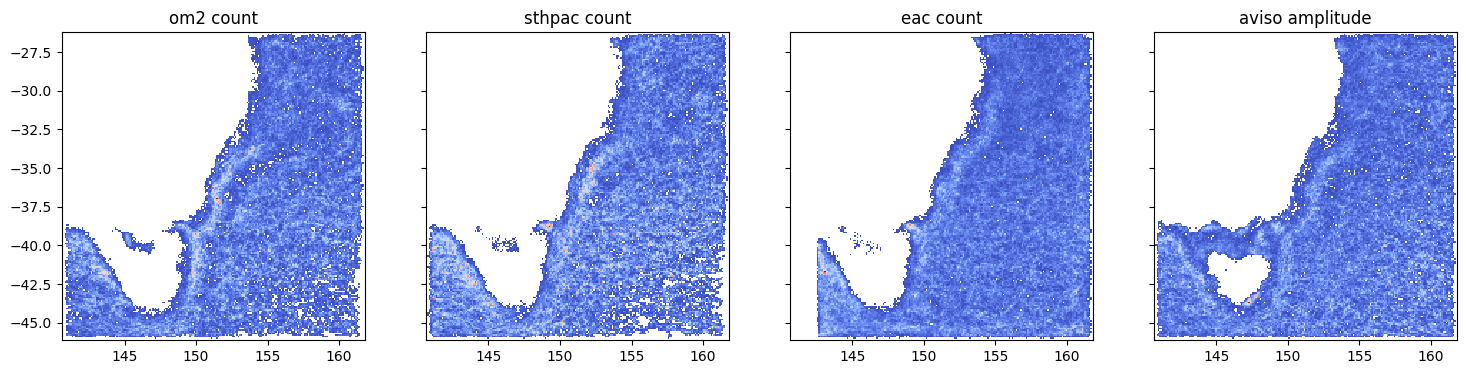

In [19]:
# Plot AC amplitudes of all data over four subplots
## get the coord bounds for taking the pixel averages
coord_bounds = {'W':aviso_ssh.longitude.min().values, 'E':aviso_ssh.longitude.max().values,
                'S':aviso_ssh.latitude.min().values, 'N':aviso_ssh.latitude.max().values}

fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(18,4))

# plot aviso amplitudes
g1 = aviso_ac.grid_count(((coord_bounds['W'], coord_bounds['E'], step),
                         (coord_bounds['S'], coord_bounds['N'], step)),
                         intern=True, center=True)
m1 = g1.display(axs[-1], name='count')
axs[3].set_title('aviso amplitude')

for i, model_name in enumerate(['om2','sthpac', 'eac']):
    g = model_tracks[model_name]['ac'].grid_count(((coord_bounds['W'], coord_bounds['E'], step),
                         (coord_bounds['S'], coord_bounds['N'], step)),
                           intern=True, center=True)
    m = g.display(axs[i], name='count')
    axs[i].set_title(f'{model_name} count')


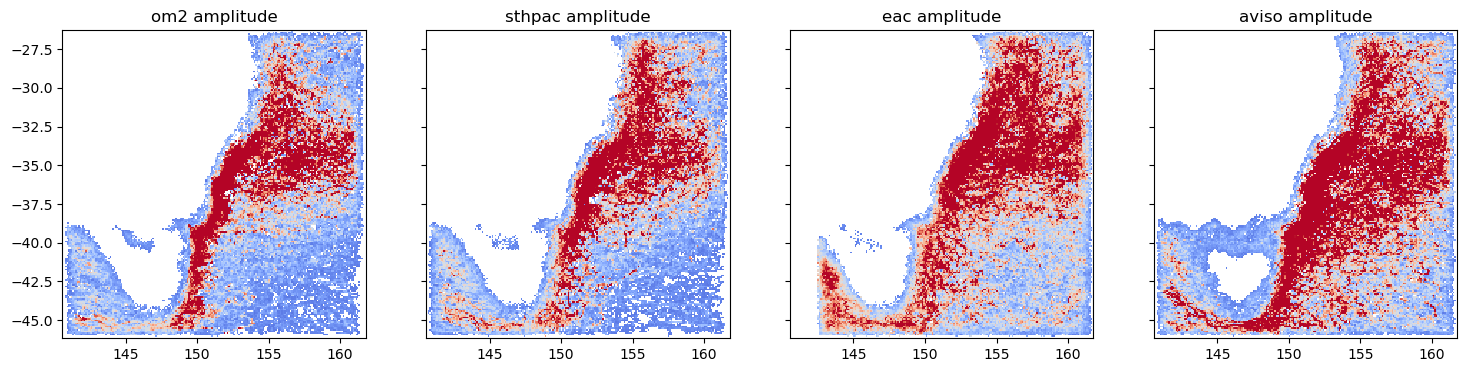

In [9]:
# Plot AC amplitudes of all data over four subplots
## get the coord bounds for taking the pixel averages
coord_bounds = {'W':aviso_ssh.longitude.min().values, 'E':aviso_ssh.longitude.max().values,
                'S':aviso_ssh.latitude.min().values, 'N':aviso_ssh.latitude.max().values}

fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(18,4))

# plot aviso amplitudes
g1 = aviso_ac.grid_stat(((coord_bounds['W'], coord_bounds['E'], step),
                         (coord_bounds['S'], coord_bounds['N'], step)),
                         varname='amplitude')
m1 = g1.display(axs[-1], name='amplitude', vmin=0, vmax=10, factor=100)
axs[3].set_title('aviso amplitude')

for i, model_name in enumerate(['om2','sthpac', 'eac']):
    g = model_tracks[model_name]['ac'].grid_stat(((coord_bounds['W'], coord_bounds['E'], step),
                         (coord_bounds['S'], coord_bounds['N'], step)),
                         varname='amplitude')
    m = g.display(axs[i], name='amplitude', vmin=0, vmax=10, factor=100)
    axs[i].set_title(f'{model_name} amplitude')


In [10]:
model_tracks['aviso'] = {'ac':aviso_ac, 'cc':aviso_cc}

So, the above is quite interesting, and to some extent further supports the "concerns" about the EAC-003 not performing great in the extension region, especially when you look at the observational data. What does this figure show? It shows the amplitudes of eddies in the region. It's extremely interesting to see this, regardless of whether it's showing what we'd hoped or not. Also interesting that both OM2 and SOUTHPAC extend all the way to the left, but EAC doesn't. Why is this? What's the minimum longitude of eac? 

Okay so this is where I got to; And it turns out that the bounds chosen for this subsetted region fall outside the bounds of the eac-003 domain. Options: just add an xlim to all maps?

Let's plot something that shows similar to the above but for the different track lengths. So we have a perhaps 4x4 grid

In [ ]:
lower = [0, 50, 100, 200, 300]
upper = [50, 100, 200, 300, -1]

fig, axs = plt.subplots(5,4, figsize=(16,16), sharex=True, sharey=True)
# loop through each track-length range as the rows of the subplots
for i, [l, u] in enumerate(zip(lower, upper)):
    # loop through each dataset for each of the different track-lengths
    for j, model_name in enumerate(['om2','sthpac', 'eac','aviso']):
        # select the ac tracks for each individual dataset
        ac_track = model_tracks[model_name]['ac']
        # filter the tracks by the given lower and upper bounds
        ac_track_filt = ac_track.extract_with_length((l,u))
        axs[i,j].set_title(f'{model_name}| N: {ac_track_filt.nb_tracks} | T: {l} to {u} days')
        m = ac_track_filt.scatter(axs[i,j], 'age', ref=-10, s=1)
        
        
    

In [ ]:
# PLOT AMPLITUDES AVERAGED OVER GRID-BOXES
lower = [0, 50, 100, 200, 300]
upper = [50, 100, 200, 300, -1]

fig, axs = plt.subplots(5,4, figsize=(16,16), sharex=True, sharey=True)
# loop through each track-length range as the rows of the subplots
for i, [l, u] in enumerate(zip(lower, upper)):
    # loop through each dataset for each of the different track-lengths
    for j, model_name in enumerate(['om2','sthpac', 'eac','aviso']):
        # select the ac tracks for each individual dataset
        ac_track = model_tracks[model_name]['ac']
        # filter the tracks by the given lower and upper bounds
        ac_track_filt = ac_track.extract_with_length((l,u))
        axs[i,j].set_title(f'{model_name}| T: {l} to {u} days')
        g = ac_track_filt.grid_stat(((coord_bounds['W'], coord_bounds['E'], step),
                                    (coord_bounds['S'], coord_bounds['N'], step)),
                                    varname='amplitude')
        m = g.display(axs[i,j], name='amplitude', vmin=0, vmax=10, factor=100)
        
fig.suptitle('Amplitudes averaged by 0.1 degree box')
    

In [20]:
import cmocean as cm

In [ ]:
aviso_ac.

In [ ]:
# filter out all eddies under 50 days


FileNotFoundError: [Errno 2] No such file or directory: b'array'

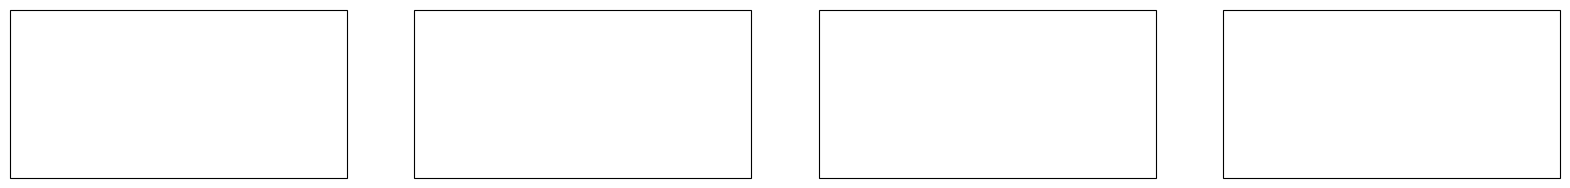

In [29]:
# Plot AC amplitudes of all data over four subplots
## get the coord bounds for taking the pixel averages
coord_bounds = {'W':aviso_ssh.longitude.min().values, 'E':aviso_ssh.longitude.max().values,
                'S':aviso_ssh.latitude.min().values, 'N':aviso_ssh.latitude.max().values}

fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(20,5), subplot_kw={'projection':ccrs.PlateCarree()})

# plot aviso amplitudes
g1 = aviso_ac.grid_stat(((coord_bounds['W'], coord_bounds['E'], step),
                         (coord_bounds['S'], coord_bounds['N'], step)),
                         varname='amplitude')
m1 = g1.display(axs[-1], name='track', vmin=0, vmax=15, factor=100, transform=ccrs.PlateCarree())
axs[3].set_title(f'aviso| N. tracks: {aviso_ac.nb_tracks}')
axs[3].coastlines()
axs[3].add_feature(feature.LAND)

gs = axs[3].gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0.5, linestyle='--')
gs.top_labels=False
gs.right_labels=False

for i, model_name in enumerate(['om2','sthpac', 'eac']):
    g = model_tracks[model_name]['ac'].grid_stat(((coord_bounds['W'], coord_bounds['E'], step),
                         (coord_bounds['S'], coord_bounds['N'], step)),
                         varname='amplitude')
    m = g.display(axs[i], name='amplitude', vmin=0, vmax=15, factor=100, transform=ccrs.PlateCarree())
    axs[i].set_title(f'{model_name}| N. tracks: {model_tracks[model_name]["ac"].nb_tracks}')
    axs[i].add_feature(feature.LAND)
    axs[i].coastlines()

    axs[i].set_xlim(eac_ssh.lon.min().values, eac_ssh.lon.max().values)
    axs[i].set_ylim(eac_ssh.lat.min().values, eac_ssh.lat.max().values)
    gs = axs[i].gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0.5, linestyle='--')
    gs.top_labels=False
    gs.right_labels=False

fig.suptitle('Anticyclonic Eddies - Mean Amplitude per 0.1 degree box', fontsize=22, fontstyle='italic')
cb = fig.colorbar(m, cax=fig.add_axes([0.14, 0.05, 0.75, 0.03]), orientation='horizontal')
cb.set_label('Amplitude (cm)', fontsize=16)

FileNotFoundError: [Errno 2] No such file or directory: b'array'

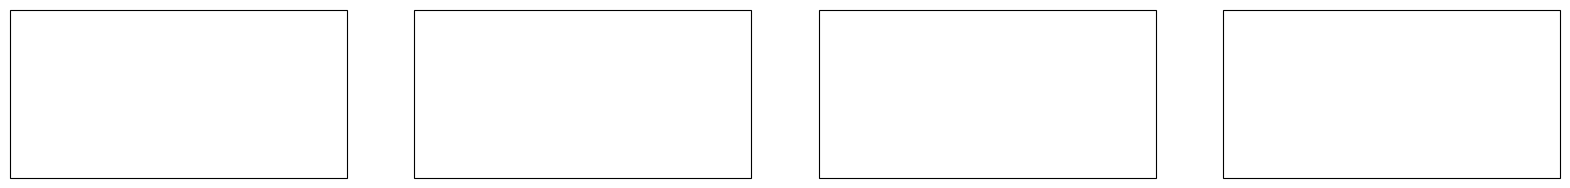

In [29]:
# Plot AC amplitudes of all data over four subplots
## get the coord bounds for taking the pixel averages
coord_bounds = {'W':aviso_ssh.longitude.min().values, 'E':aviso_ssh.longitude.max().values,
                'S':aviso_ssh.latitude.min().values, 'N':aviso_ssh.latitude.max().values}

fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(20,5), subplot_kw={'projection':ccrs.PlateCarree()})

# plot aviso amplitudes
g1 = aviso_ac.grid_stat(((coord_bounds['W'], coord_bounds['E'], step),
                         (coord_bounds['S'], coord_bounds['N'], step)),
                         varname='amplitude')
m1 = g1.display(axs[-1], name='track', vmin=0, vmax=15, factor=100, transform=ccrs.PlateCarree())
axs[3].set_title(f'aviso| N. tracks: {aviso_ac.nb_tracks}')
axs[3].coastlines()
axs[3].add_feature(feature.LAND)

# gs = axs[3].gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0.5, linestyle='--')
# gs.top_labels=False
# gs.right_labels=False

# for i, model_name in enumerate(['om2','sthpac', 'eac']):
#     g = model_tracks[model_name]['ac'].grid_stat(((coord_bounds['W'], coord_bounds['E'], step),
#                          (coord_bounds['S'], coord_bounds['N'], step)),
#                          varname='amplitude')
#     m = g.display(axs[i], name='amplitude', vmin=0, vmax=15, factor=100, transform=ccrs.PlateCarree())
#     axs[i].set_title(f'{model_name}| N. tracks: {model_tracks[model_name]["ac"].nb_tracks}')
#     axs[i].add_feature(feature.LAND)
#     axs[i].coastlines()

#     axs[i].set_xlim(eac_ssh.lon.min().values, eac_ssh.lon.max().values)
#     axs[i].set_ylim(eac_ssh.lat.min().values, eac_ssh.lat.max().values)
#     gs = axs[i].gridlines(draw_labels=True, crs=ccrs.PlateCarree(), alpha=0.5, linestyle='--')
#     gs.top_labels=False
#     gs.right_labels=False

# fig.suptitle('Anticyclonic Eddies - Mean Amplitude per 0.1 degree box', fontsize=22, fontstyle='italic')
# cb = fig.colorbar(m, cax=fig.add_axes([0.14, 0.05, 0.75, 0.03]), orientation='horizontal')
# cb.set_label('Amplitude (cm)', fontsize=16)